In [1]:
import pandas as pd 
import googlemaps
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import plotly.express as px
from collections import Counter

In [ ]:
# Tu clave de API de Google
API_KEY = "#####"

# Inicializar cliente de Google Maps
gmaps = googlemaps.Client(key=API_KEY)


In [ ]:
# Definir ubicación (Barranquilla, Colombia)
location = {'lat': 10.9685, 'lng': -74.7813}

# Variables para almacenar todos los IDs de lugar
all_place_ids = []
total_places = 0

# Iniciar búsqueda de restaurantes
while total_places<6000:
    # Buscar restaurantes cercanos
    places = gmaps.places_nearby(location=location, radius=500, type='restaurant')

    # Recopilar IDs de lugar
    place_ids = [place['place_id'] for place in places['results']]
    all_place_ids.extend(place_ids)
    
    # Contar la cantidad total de lugares recopilados hasta el momento
    total_places += len(place_ids)

    # Mostrar el progreso
    print(f"Lugares recopilados: {total_places}")

    # Verificar si hay más páginas de resultados
    next_page_token = places.get('next_page_token')
    if not next_page_token:
        break
    # Esperar unos segundos antes de hacer la siguiente solicitud para permitir que se procese el token de página
    time.sleep(2)
    # Hacer la siguiente solicitud utilizando el token de página
    places = gmaps.places_nearby(page_token=next_page_token)

# Imprimir la cantidad total de IDs de lugar recopilados
print(f"Total de IDs de lugar recopilados: {len(all_place_ids)}")

In [ ]:
# Crear una lista para almacenar los datos de las reseñas
data = []

restaurant_count=0

# Obtener detalles de cada restaurante y sus reseñas
for place_id in all_place_ids:
    
    restaurant_count += 1
    # Imprimir el ID actual y el número de filas en el DataFrame
    print(f"Restaurante: {restaurant_count}, Filas de reseñas: {len(data)}")
    
    place_details = gmaps.place(place_id=place_id)
    restaurant_name = place_details['result']['name']
    latitude = place_details['result']['geometry']['location']['lat']
    longitude = place_details['result']['geometry']['location']['lng']
    price_level = place_details['result'].get('price_level', '')
    reviews = place_details['result'].get('reviews', [])
    # Iterar sobre las reseñas y agregar los datos al DataFrame
    for review in reviews:
        review_data = {
            'ID restaurante': place_id,
            'nombre restaurante': restaurant_name,
            'calificacion': review['rating'],
            'latitud': latitude,
            'longitud': longitude,
            'rango de precios': price_level,
            'reseña': review['text']
        }
        data.append(review_data)

# Crear un DataFrame a partir de la lista de datos
df = pd.DataFrame(data)

In [58]:
df= pd.read_excel(r"RestaurantReviews.xlsx")

In [38]:
df.drop(["ID restaurante"],inplace=True,axis=1)

In [39]:
df.columns

Index(['nombre restaurante', 'calificacion', 'latitud', 'longitud',
       'rango de precios', 'reseña'],
      dtype='object')

In [40]:
df = df.rename(columns={"nombre restaurante": "restaurante",
                        "rango de precios": "precios",
                        "calificacion": "score",
                        "reseña": "resena"})


In [24]:
df.head()

,restaurante,score,latitud,longitud,precios,resena
0,empanadas sabrositas,1,10.969115,-74.781151,NaN,They sold me a cold one
1,empanadas sabrositas,5,10.969115,-74.781151,NaN,Servimetales S.A.S
2,Restaurante La Flor Del Pollo,3,10.967886,-74.781711,NaN,"Good, although their tripe is great and also t..."
3,Restaurante La Flor Del Pollo,5,10.967886,-74.781711,NaN,Excellent tripe soups!!!
4,Restaurante La Flor Del Pollo,4,10.967886,-74.781711,NaN,Good and economical


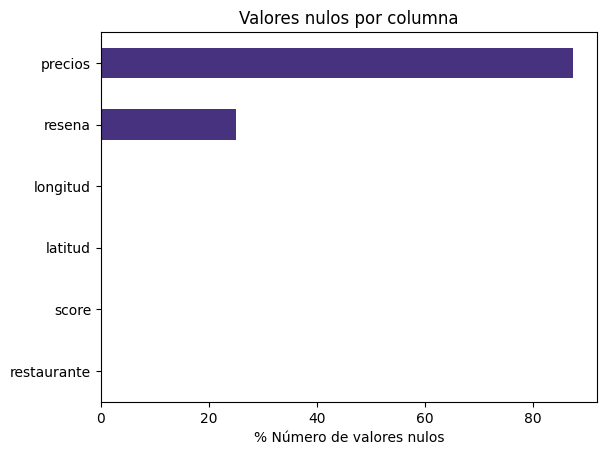

In [26]:
def plot_null_values(dataframe):
    null_values = dataframe.isnull().sum()*100/len(dataframe)
    null_values.sort_values(inplace=True)
    
    # Grafica los valores nulos
    null_values.plot.barh()
    plt.title('Valores nulos por columna')
    plt.xlabel('% Número de valores nulos')
    plt.show()

plot_null_values(df)

Debido a la alta cantidad de faltantes en la información de rango de precios, se procede a eliminar esta columna. Así como también se eliminarán, las reseñas que no tienen comentarios. 

In [41]:
df.drop(["precios"],inplace=True,axis=1)

In [42]:
df = df[df["resena"].notna()]

c:\Users\Analista BI\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\Analista BI\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\Analista BI\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead



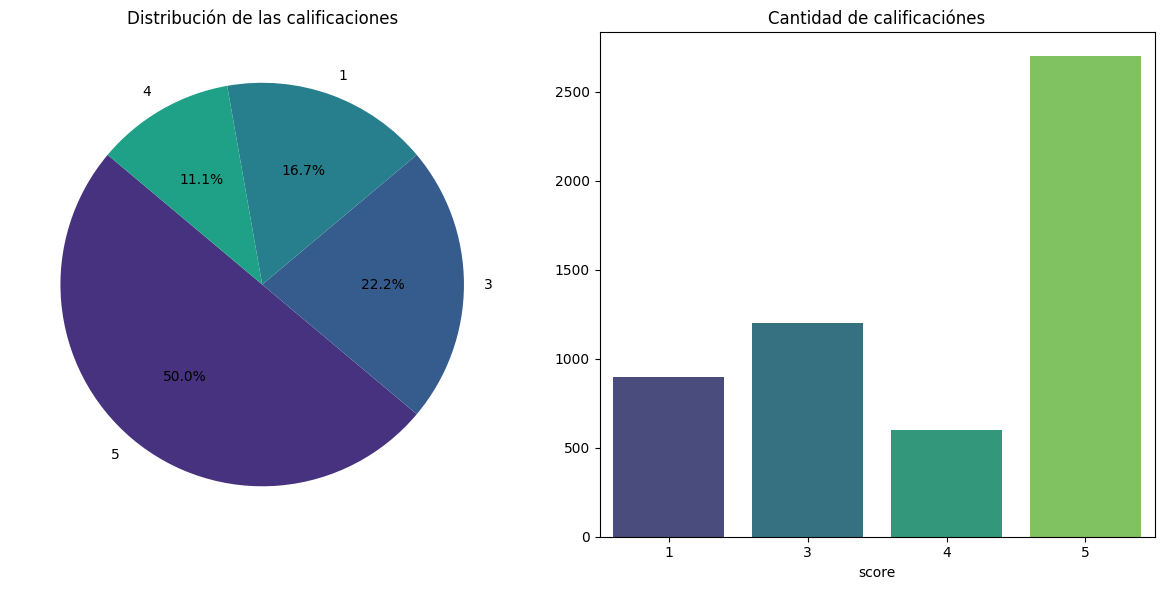

In [29]:
# Value Count Of Label
count = df['score'].value_counts()

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6), facecolor='white')

# Plot pie chart on the first subplot
palette = sns.color_palette("viridis")
sns.set_palette(palette)
axs[0].pie(count, labels=count.index, autopct='%1.1f%%', startangle=140)
axs[0].set_title('Distribución de las calificaciones')

# Plot bar chart on the second subplot
sns.barplot(x=count.index, y=count.values, ax=axs[1], palette="viridis")
axs[1].set_title('Cantidad de calificaciónes')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

Tenemos un sistema de puntuación del 1 al 5. Se observa que más de la mitad de las reseñas son de valor de 5 (54.9%) lo que puede llevar a un desbalance de clases. Es por esto que procederemos a tratar las reseñas 4 y 5 como valor positivo y el resto (1 a 3) como reseñas negativas.

In [43]:
dff= df.copy()

In [44]:
dff.score[dff.score<=3]=0
dff.score[dff.score>=4]=1

C:\Users\Analista BI\AppData\Local\Temp\ipykernel_17936\2198666721.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Analista BI\AppData\Local\Temp\ipykernel_17936\2198666721.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



c:\Users\Analista BI\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\Analista BI\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\Analista BI\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead



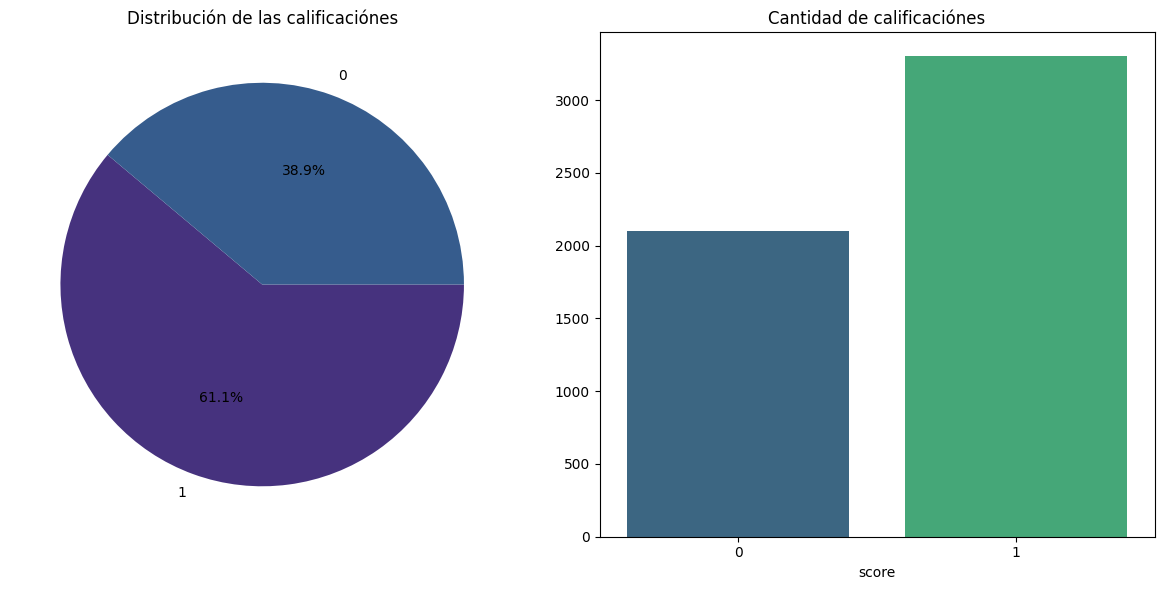

In [45]:
# Value Count Of Label
count = dff['score'].value_counts()

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6), facecolor='white')

# Plot pie chart on the first subplot
palette = sns.color_palette("viridis")
sns.set_palette(palette)
axs[0].pie(count, labels=count.index, autopct='%1.1f%%', startangle=140)
axs[0].set_title('Distribución de las calificaciónes')

# Plot bar chart on the second subplot
sns.barplot(x=count.index, y=count.values, ax=axs[1], palette="viridis")
axs[1].set_title('Cantidad de calificaciónes')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In [46]:
dff["resena"].head(9)

0                              They sold me a cold one
1                                   Servimetales S.A.S
2    Good, although their tripe is great and also t...
3                             Excellent tripe soups!!!
4                                  Good and economical
5                                              Regular
7                                                 good
8                                                   👍👍
9    An excellent place to enjoy a pleasant moment ...
Name: resena, dtype: object

Observamos que aunque no se haya realizado una reseña no signfica que necesariamente signifca que no se haya hecho una calificación positiva al restaurante.

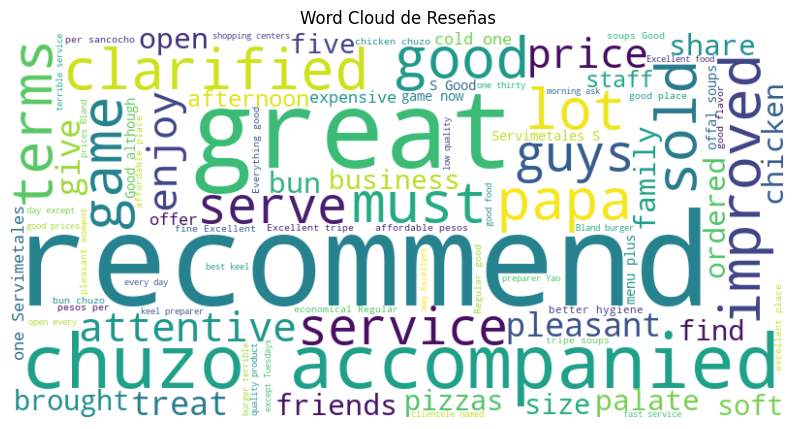

In [47]:
# Concatenar todas las reseñas en una sola cadena
all_reviews = ' '.join(dff['resena'].dropna())

# Crear el objeto WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_reviews)

# Mostrar la nube de palabras
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud de Reseñas')
plt.axis('off')
plt.show()

En general se observa que hay buenas reseñas, esto esta alineado con la grafica de countplot presentada anteriormente donde hay mas calificaciones de 5 y 4, que 3, 2 y 1.

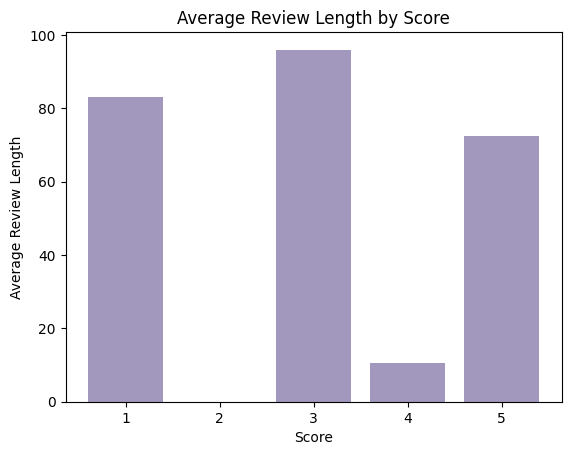

In [48]:
df['review_length'] = df['resena'].apply(lambda x: len(x) if isinstance(x, str) else 0)

# Calcular el largo promedio de las reseñas por score
average_lengths = df.groupby('score')['review_length'].mean()

# Graficar
plt.bar(average_lengths.index, average_lengths.values, alpha=0.5)
plt.xlabel('Score')
plt.ylabel('Average Review Length')
plt.title('Average Review Length by Score')
plt.show()

La gente suele extenderse un poco más en sus reseñas cuando la calificación al restaurante es 3, probablemente porque necesitan dar más explicación sobre el por qué no consideran que el restaurante sea bueno o malo.

In [55]:
df["restaurante"].unique()

array(['empanadas sabrositas', 'Restaurante La Flor Del Pollo',
       'Restaurante comidas rápidas kataleya',
       'Puerta De Oro Gourmet,Restaurante,Cafeteria', 'Subway',
       "Comidas Rápidas Son D'licias", 'Lucas Burgues', 'GORDO PIZZA'],
      dtype=object)

In [18]:
# Crear un gráfico de dispersión en el mapa
fig = px.scatter_mapbox(df, lat="latitud", lon="longitud", color="score",
                        color_continuous_scale=px.colors.sequential.Blues,  # Cambiar la paleta de colores
                        size_max=15, zoom=12)

# Configurar el mapa
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()
